# Week 5 - Sampling & Reliability




In [3]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
import numpy as np #For arrays
import scipy as sp #For some stats
import pandas as pd#Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math


#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

# What?

We propose to study the differences in the ways that male and female journalists interview male and female celebrities in politics, cinema, music and sports. We intend to do this by analyzing the topics discussed, rhetoric employed and  the types of descriptors used in each of the four categories of interviewer-interviewee pairs. We also want to understand if any differences we might find persist across the elite-popular spectrum of magazines.

To this end, we will procure interviews from several magazines including from Elle, Volgue, Vanity Fair, Rolling Stone, the New Yorker, Time Magazine, New York Times, the Washington Post, etc., categorize them into 'male-female', 'female-female' etc. depending on the gender identification of the interviewer and the interviewee.

# Why?

Interviews are an important way for successful people in several fields, particularly those where celebrities are created, to narrate their stories, document their struggles, contextualize their accomplishments and present themselves as 'real people' to those who follow their work. Interviewers play a key role as story-tellers here - the questions they ask, the stories they choose to highlight, the context and framing they provide are instrumental in shaping the message that's ultimately communicated to the reader. 

In May 2017, Hadley Freeman wrote (https://www.theguardian.com/fashion/2017/mar/20/male-journalists-female-stars-flirting-vogue-profile-selena-gomez-interviewing) about how male journalists have been sexualizing their female interviewees for many years now. In 1999, a cover article about Britney Spears (who was, at the time, a minor) in the Rolling Stone starts with "Britney Spears extends a honeyed thigh across the length of the sofa, keeping one foot on the floor as she does so."
Here's one from the New Yorker - an interview of the actress Scarlett Johansson in the New Yorker (!) include the words ""Would it be construed as trespass, therefore, to state that Johansson looks tellingly radiant in the flesh? Mind you, she rarely looks unradiant, so it’s hard to say whether her condition [pregnancy] has made a difference." 

We are interested in applying computational tools to investigate this further. Do men interviewing women spent inordinate column space on physical descriptions? Are the topics discussed in each interviewer-interviewee pair category different? Do some categories have more diversity of subjects, more camaraderie, more hostility than others? 

# How?

Our first step will be to describe the data using word counts and distribution plots, split up by gender and industry based categories, to examine the differences, if any, in the language used across these categories. We will scour the data for any telling collocations or n-grams. We're curious to see whether clustering techniques will cluster along the axis of gender categories or industries - for instance, do male journalists describe female interviewees similarly across all industry contexts?

Our next step would be to use a topic modelling approach to discern the broad categories discussed in interviews. For instance, we hypothesize that topics revolving around family and 'settling down' are more likely to be brought up when the interviewee is female. The topic modelling exercise would lead us to a finite subset of words and phrases on which to do a word embedding analysis. First, we would explore other words that are closely related to our words of interest and explore how these change across gender categories and industries.

To explore in further detail the anecdotal evidence that male journalists describe their female interviewees in sexualized terms (see https://www.vox.com/2016/7/12/12110190/sexist-celebrity-profiles-margot-robbie-renee-zellweger), we are curious to see the similarities and divergences between descriptions of women in erotic literature and interviews in our dataset.

## Which (words)?

We used the ranking produced by PSA Research Center on the most circulated magazines in 2017 and then picked the top 10 magazines that had at least 100 interviews. We will proceed to scrape these 10 magazines for their last 100 interviews, giving us a corpus of 1000 interviews to analyze. Steps will have to be taken to stratify this sample if we do not have sufficient representation in each category. 

The major limitation we anticpate running into is a paywall - we will attempt to circumvent this by accessing the UChicago Library's resources. We will also endeavour to ensure that our scraper is rate-limited and doesn't raise any red flags on magazine websites. If a paywall (and our own abject poverty) interferes with our access to some magazines, that will raise concerns about how representative our sample is. A reasonable first step to scaling up would be to acquire a significantly larger and more diverse dataset.

## Exercise 1

(a) To preprocess interviews, we will tokenize, normalize and then use tf-idf to remove words that are very frequently used across all interviews.

(b) We will use topic modeling to identify the main topics of discussion in various interviews. 

(c) We will use these topics to create meaningful word embeddings to assess differences/ similarities across categories.

##  *Excercise 2*

For the purposes of this exercise, I had 4 coders rank 100 different snippets of text on a scale of 1-4, where 1 represents 'Gender Neutral' and 4 represents 'Highly Misogynistic'.

An example of what I would personally classify as 4 would be "Alicia Silverstone is a kittenish 18-year-old movie star whom lots of men want to sleep with."

An example of what I would classifiy as 1 would be "Serena Williams spent her teenage years practicing for at least six hours a day".

In [9]:
x = np.loadtxt("filename.txt")
anno = AnnotationsContainer.from_array(x_arr, missing_values=[-1])

In [10]:
anno.labels

[1.0, 2.0, 3.0, 4.0]

In [11]:
anno.missing_values

[-1]

## It's interesting to note that only 15% of statements were classified as 'Gender Neutral'. 

In [12]:
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

array([ 0.1509434 ,  0.25786164,  0.33333333,  0.25786164])

## Coders 0 and 3 have very different opinions from each other, as seen in this heat map that represents a confusion matrix of coded agreements between coders.

[[ 1.  0.  2.  0.]
 [ 1.  5.  1.  0.]
 [ 0.  1.  6.  0.]
 [ 0.  2.  2.  3.]]


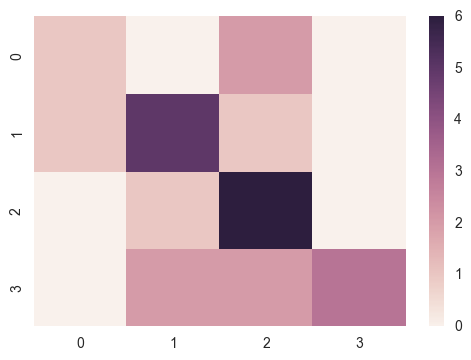

In [13]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

In [38]:
# Scott's pi for first two coders
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])


0.48783610755441742

In [15]:
krippendorffs_alpha(anno.annotations[::])

0.68635110294117641

In [39]:
# Cohen's kapa for first two coders
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.49566779374471676

## As we would expect, Krippendorff's Alpha is higher than the other measures because it takes into account 'distances' of disagreement - i.e., two coders that rate the same thing 1 and 2 are seen as less divergent than two codes that rate the same thing 1 and 4.

In [17]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[ 1.          0.49566779  0.45954438         nan]
 [ 0.49566779  1.          0.59088576  0.46685879]
 [ 0.45954438  0.59088576  1.          0.45974026]
 [        nan  0.46685879  0.45974026  1.        ]]


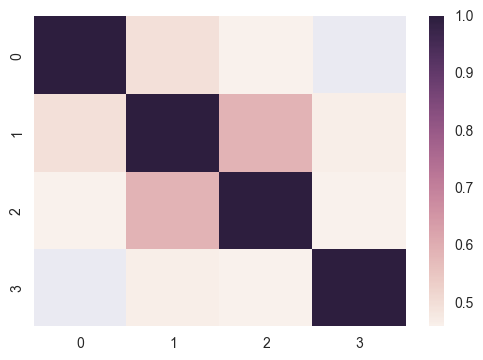

In [18]:
ax = seaborn.heatmap(m)
plt.show()

In [19]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, anno.annotations)

0.49453939649776563

In [20]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.52439753495217079

In [21]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.58889720053733718

### Again, a weighted measure shows more average correlation across coders


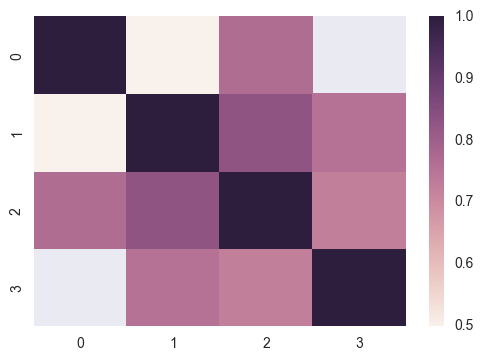

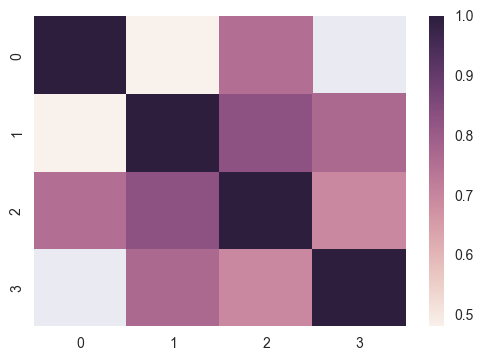

In [22]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

In [23]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.716051375925 0.706219276074


# Exercise 3

In [64]:
# create a new instance of model B, with 4 label classes
model = ModelB.create_initial_state(4,4)


In [54]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 100, burn_in_samples=50, thin_samples=3)

In [55]:
model.map(anno.annotations)


In [56]:
posterior = model.infer_labels(anno.annotations)

In [57]:
def makeQuestionComparison(model, anno_target, num_questions = 20):
    votes = []
    for r in anno_target.annotations:
        v = [0] * len(anno_target.labels)
        votes.append(v)
        for a in r:
            if a > -1:
                v[a] += 1
    votes_array = np.array(votes)
    posterior = model.infer_labels(anno_target.annotations)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)

    seaborn.heatmap(votes_array[:num_questions], annot = True, ax=ax2)
    seaborn.heatmap(np.nan_to_num(posterior,0)[:num_questions], annot=True, ax =ax1)
    ax1.set_title("Model")
    ax2.set_title("Votes")
    return fig, (ax1, ax2)

(<matplotlib.figure.Figure at 0x11b849eb8>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x11b841208>,
  <matplotlib.axes._subplots.AxesSubplot at 0x11be9a710>))

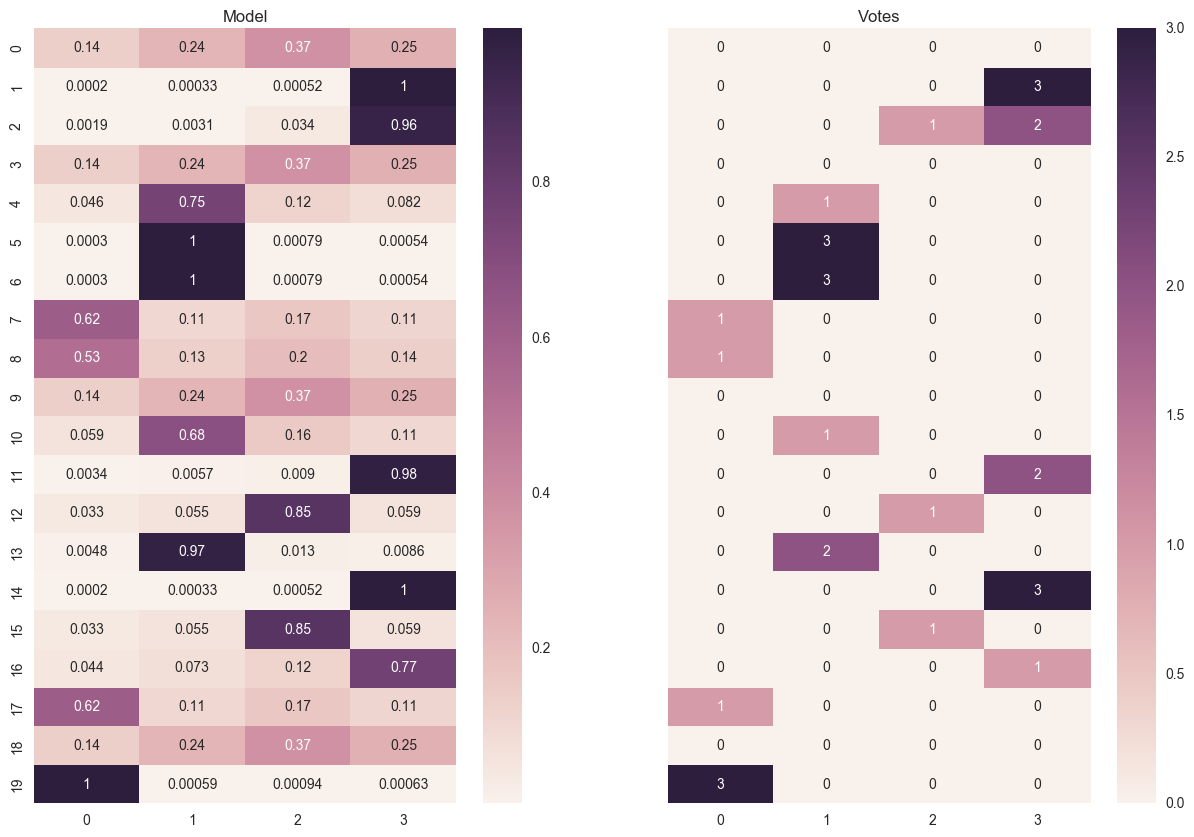

In [58]:
makeQuestionComparison(model, anno)


In [59]:
# create a new instance of model B, with 4 label classes and 8 annotators.
model = ModelBt.create_initial_state(4, 4)


In [60]:
model.map(anno.annotations)


In [65]:
s = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)


In [66]:
posterior = model.infer_labels(anno.annotations)


(<matplotlib.figure.Figure at 0x11c2bccc0>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x11c6f42b0>,
  <matplotlib.axes._subplots.AxesSubplot at 0x11d265d68>))

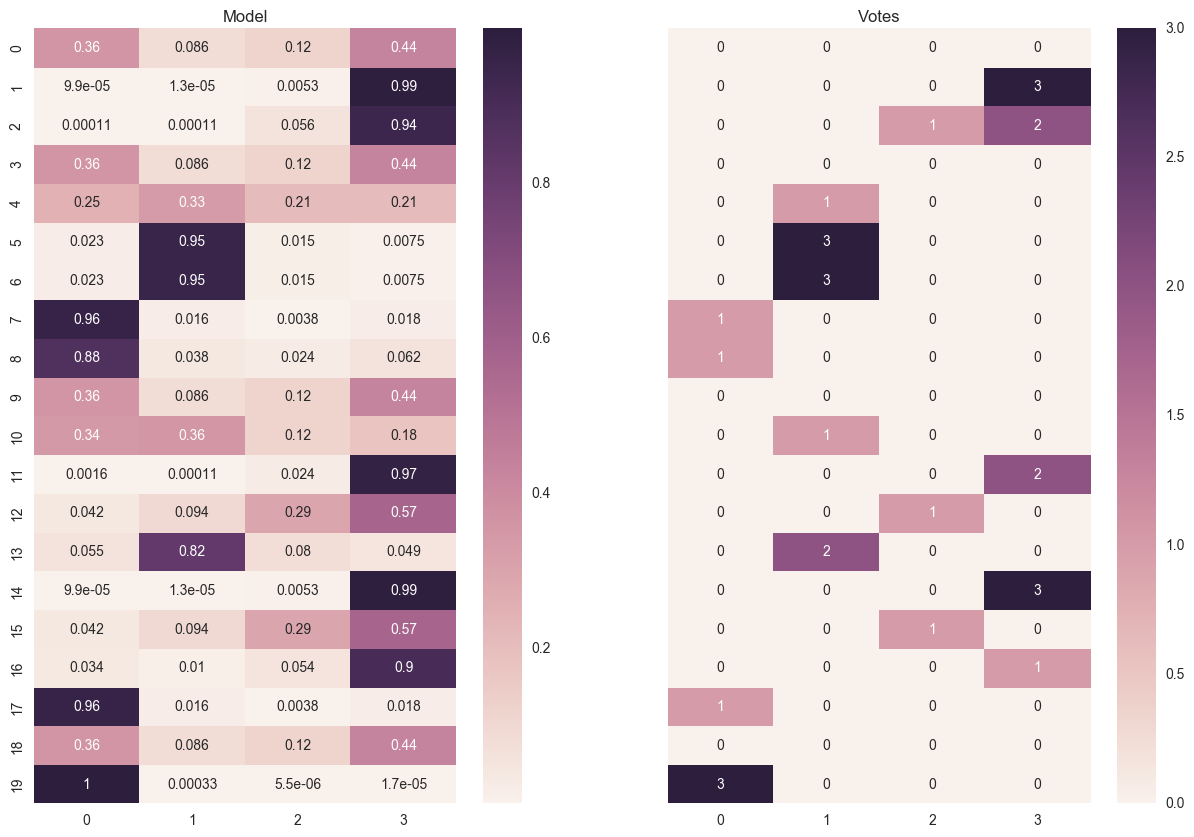

In [67]:
makeQuestionComparison(model, anno)

## In the visualization of both models, we have model-based probabilities on the left and the (same) raw votes on the right. We can see how bad coders are significantly downweighted in making decisions

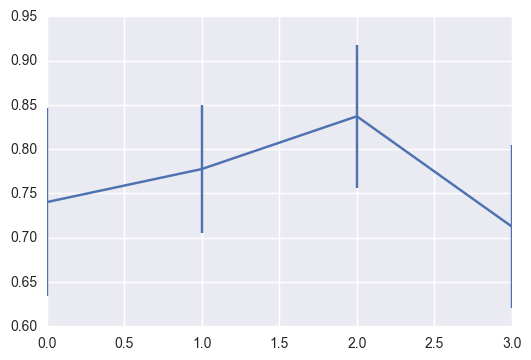

In [69]:
model = ModelBt.create_initial_state(4,4)
model.mle(anno.annotations)
samples = model.sample_posterior_over_accuracy(anno.annotations, 100, burn_in_samples=50, thin_samples=3)
y =  samples.mean(axis=0)
y_ci = samples.std(axis=0)
plt.figure()
plt.errorbar(range(4),y, yerr = y_ci)
plt.show()

## Coder Accuracy - We see that the coder #4 is the least accurate - although #0 is nearly as inaccurate - and even they are > 70% accurate.